# Loading Dataset & Preparing Data

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# load dataset


In [3]:
data = load_breast_cancer()
X = data.data
y = data.target

# Train validation split

In [15]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.6, random_state=42
)


X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)


# Feature Scaling

In [16]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


# Converting to PyTorch tensors

In [17]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


# Building a Neaural Netwrk

I am intentionally using a slightly deep model to create overfitting

In [18]:
class OverfitNN(nn.Module):
    def __init__(self):
        super(OverfitNN, self).__init__()
        self.fc1 = nn.Linear(30, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.sigmoid(self.fc5(x))
        return x


# Training Functions

In [19]:
def train_model(model, optimizer, epochs=100):
    criterion = nn.BCELoss()

    train_loss, val_loss = [], []
    train_acc, val_acc = [], []

    for epoch in range(epochs):
        # Training
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train).squeeze()
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        preds = (outputs >= 0.5).float()
        acc = (preds == y_train).float().mean()

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val).squeeze()
            v_loss = criterion(val_outputs, y_val)
            v_preds = (val_outputs >= 0.5).float()
            v_acc = (v_preds == y_val).float().mean()

        train_loss.append(loss.item())
        val_loss.append(v_loss.item())
        train_acc.append(acc.item())
        val_acc.append(v_acc.item())

    return train_loss, val_loss, train_acc, val_acc


# WITHOUT REGULARIZATION

In [20]:
model_no_reg = DeepNN()
optimizer_no_reg = optim.Adam(model_no_reg.parameters(), lr=0.001)

loss_tr, loss_val, acc_tr, acc_val = train_model(
    model_no_reg, optimizer_no_reg, epochs=200
)

In [21]:
print("Final Training Accuracy:", acc_tr[-1])
print("Final Validation Accuracy:", acc_val[-1])

print("Final Training Loss:", loss_tr[-1])
print("Final Validation Loss:", loss_val[-1])


Final Training Accuracy: 1.0
Final Validation Accuracy: 0.9532163739204407
Final Training Loss: 0.011094657704234123
Final Validation Loss: 0.10299400240182877


# L2 Regularization

In [22]:
model_l2 = DeepNN()
optimizer_l2 = optim.Adam(
    model_l2.parameters(), lr=0.001, weight_decay=0.01
)

loss_tr_l2, loss_val_l2, acc_tr_l2, acc_val_l2 = train_model(model_l2, optimizer_l2)


In [23]:
print("L2 Regularization Results")
print("Final Training Accuracy:", acc_tr_l2[-1])
print("Final Validation Accuracy:", acc_val_l2[-1])
print("Final Training Loss:", loss_tr_l2[-1])
print("Final Validation Loss:", loss_val_l2[-1])


L2 Regularization Results
Final Training Accuracy: 0.9823788404464722
Final Validation Accuracy: 0.9415204524993896
Final Training Loss: 0.07432183623313904
Final Validation Loss: 0.10350234806537628


# L1 REGULARIZATION

Python doesnt support L1 regularization. so here adding l1 penalty to the loss

In [25]:
def l1_penalty(model, l1_lambda=0.001):
    l1_norm = 0
    for param in model.parameters():
        l1_norm += torch.sum(torch.abs(param))
    return l1_lambda * l1_norm


# Training function for L1

In [26]:
def train_model_l1(model, optimizer, epochs=200, l1_lambda=0.001):
    criterion = nn.BCELoss()

    train_loss, val_loss = [], []
    train_acc, val_acc = [], []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        outputs = model(X_train).squeeze()
        loss = criterion(outputs, y_train) + l1_penalty(model, l1_lambda)
        loss.backward()
        optimizer.step()

        preds = (outputs >= 0.5).float()
        acc = (preds == y_train).float().mean()

        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val).squeeze()
            v_loss = criterion(val_outputs, y_val)
            v_preds = (val_outputs >= 0.5).float()
            v_acc = (v_preds == y_val).float().mean()

        train_loss.append(loss.item())
        val_loss.append(v_loss.item())
        train_acc.append(acc.item())
        val_acc.append(v_acc.item())

    return train_loss, val_loss, train_acc, val_acc


In [27]:
model_l1 = OverfitNN()
optimizer_l1 = optim.Adam(model_l1.parameters(), lr=0.001)

loss_tr_l1, loss_val_l1, acc_tr_l1, acc_val_l1 = train_model_l1(
    model_l1, optimizer_l1, epochs=200, l1_lambda=0.001
)


In [28]:
print("L1 Regularization Results")
print("Final Training Accuracy:", acc_tr_l1[-1])
print("Final Validation Accuracy:", acc_val_l1[-1])
print("Final Training Loss:", loss_tr_l1[-1])
print("Final Validation Loss:", loss_val_l1[-1])


L1 Regularization Results
Final Training Accuracy: 0.9955947399139404
Final Validation Accuracy: 0.9532163739204407
Final Training Loss: 0.20695987343788147
Final Validation Loss: 0.10150323808193207


# Elastic Net

In [29]:
model_elastic = OverfitNN()

optimizer_elastic = optim.Adam(
    model_elastic.parameters(),
    lr=0.001,
    weight_decay=0.01   # L2 part
)

loss_tr_en, loss_val_en, acc_tr_en, acc_val_en = train_model_l1(
    model_elastic,
    optimizer_elastic,
    epochs=200,
    l1_lambda=0.001     # L1 part
)


In [30]:
print("Elastic Net Results")
print("Final Training Accuracy:", acc_tr_en[-1])
print("Final Validation Accuracy:", acc_val_en[-1])
print("Final Training Loss:", loss_tr_en[-1])
print("Final Validation Loss:", loss_val_en[-1])


Elastic Net Results
Final Training Accuracy: 0.9867841601371765
Final Validation Accuracy: 0.9590643048286438
Final Training Loss: 0.19722631573677063
Final Validation Loss: 0.09210308641195297


# Visualization

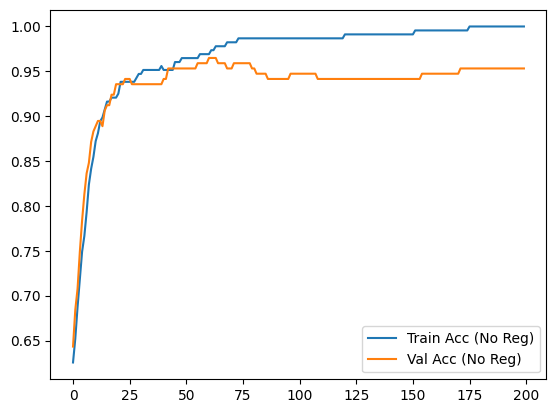

In [32]:
plt.plot(acc_tr, label="Train Acc (No Reg)")
plt.plot(acc_val, label="Val Acc (No Reg)")
plt.legend()
plt.show()


# visual comparison

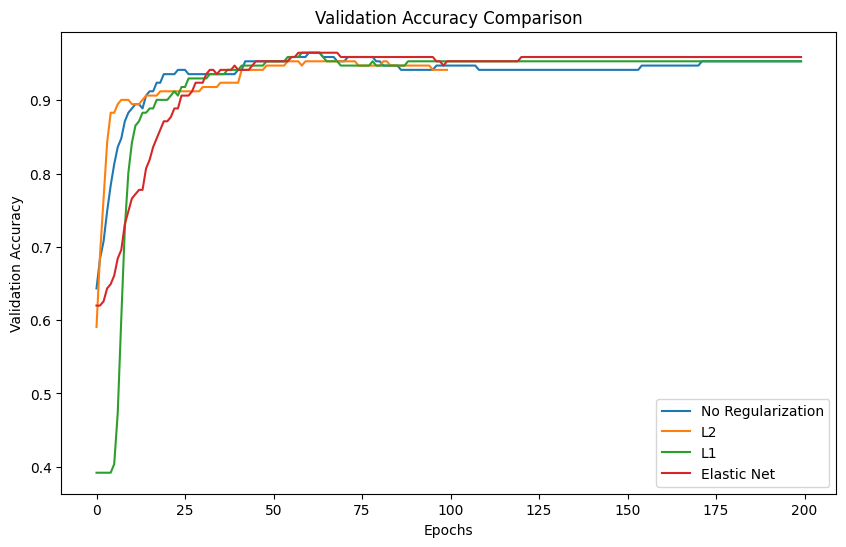

In [33]:
plt.figure(figsize=(10,6))
plt.plot(acc_val, label="No Regularization")
plt.plot(acc_val_l2, label="L2")
plt.plot(acc_val_l1, label="L1")
plt.plot(acc_val_en, label="Elastic Net")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy Comparison")
plt.legend()
plt.show()
